In [14]:
! pip install pyreadstat pyarrow matplotlib


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [15]:
import pandas as pd

Taiwan_QQQ = pd.read_feather("Cleaned_2018_Math.feather")

# 切割資料集為訓練集和測試集
from sklearn.model_selection import train_test_split
X = Taiwan_QQQ.drop(['Math_level'], axis=1)
y = Taiwan_QQQ['Math_level']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
from sklearn.feature_selection import mutual_info_classif
import pandas as pd

mi = mutual_info_classif(X_train, y_train)
mi_scores = pd.Series(mi, index=X.columns)
mi_scores = mi_scores.sort_values(ascending=False)  # 降序排序
print(mi_scores[:100])

JOYREAD       0.088007
ST165Q04IA    0.078308
METASUM       0.076610
ST225Q06HA    0.073653
MMINS         0.067417
                ...   
USESCH        0.026429
EMOSUPS       0.026189
IC152Q07HA    0.026004
ICTCLASS      0.025737
ST167Q03IA    0.025599
Length: 100, dtype: float64


In [17]:
selected_column = mi_scores[:100].keys()
X_train = X_train[selected_column]
X_test = X_test[selected_column]

X_train.head()

,JOYREAD,ST165Q04IA,METASUM,ST225Q06HA,MMINS,METASPAM,GCSELFEFF,HOMESCH,RESPECT,GCAWARE,...,ST167Q04IA,ST164Q02IA,ST196Q06HA,EUDMO,ST023Q04TA,USESCH,EMOSUPS,IC152Q07HA,ICTCLASS,ST167Q03IA
571621,-0.6996,3.0,-0.18,0.0,200.0,-1.41,2.3535,-2.2971,-0.4401,0.1316,...,4.0,3.0,4.0,0.2621,3.0,-1.7161,-0.6576,1.0,-1.2188,1.0
568626,0.6380,4.0,1.36,1.0,300.0,0.42,0.8332,0.0303,-0.4401,-0.0549,...,4.0,3.0,4.0,0.2621,4.0,-0.0368,-0.6576,4.0,-0.2257,4.0
572855,-2.7114,4.0,0.21,1.0,300.0,0.42,0.1904,-2.2971,0.9289,-0.0549,...,5.0,1.0,3.0,-0.9827,3.0,-1.7161,-1.1847,1.0,1.1514,1.0
573892,-0.9615,1.0,-1.72,0.0,250.0,-1.41,-2.7142,-0.9320,-2.1937,-1.2902,...,1.0,1.0,1.0,-1.1437,1.0,-1.7161,-0.6576,1.0,-1.2188,1.0
573109,1.4712,4.0,-0.57,1.0,220.0,-0.04,-2.7142,0.4754,-1.4721,-3.4944,...,3.0,1.0,1.0,-0.3121,3.0,1.1345,-1.5824,4.0,-1.1319,4.0


In [18]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

svm_pipeline = Pipeline([('scaler', StandardScaler()), ('svm', SVC())])

# 設定參數網格
svm_param_grid = {
    'svm__C': [0.1, 1, 10],
    'svm__kernel': ['linear', 'rbf', 'poly'],
    'svm__gamma': [0.1, 1, 10]
}


# 創建 GridSearchCV 物件
svm_grid_search = GridSearchCV(svm_pipeline, svm_param_grid, cv=5, verbose=4, n_jobs=-1)

# 執行網格搜索
svm_grid_search.fit(X_train, y_train)

# 访问 cv_results_
cv_results = svm_grid_search.cv_results_

# 打印每折的验证结果
for i in range(len(cv_results['params'])):
    print("Params:", cv_results['params'][i])
    for j in range(5):  # 假设 cv=5
        print(f"Fold {j+1} score:", cv_results[f'split{j}_test_score'][i])

# 最佳參數和模型
print("Best parameters:", svm_grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(svm_grid_search.best_score_))

# 使用最佳參數的模型對測試集進行預測
best_model = svm_grid_search.best_estimator_
test_score = best_model.score(X_test, y_test)
print("Test set score: {:.2f}".format(test_score))

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Params: {'svm__C': 0.1, 'svm__gamma': 0.1, 'svm__kernel': 'linear'}
Fold 1 score: 0.7842968075927523
Fold 2 score: 0.7713546160483176
Fold 3 score: 0.7946505608283002
Fold 4 score: 0.7851596203623814
Fold 5 score: 0.7901554404145078
Params: {'svm__C': 0.1, 'svm__gamma': 0.1, 'svm__kernel': 'rbf'}
Fold 1 score: 0.5237273511647972
Fold 2 score: 0.5245901639344263
Fold 3 score: 0.5263157894736842
Fold 4 score: 0.5254529767040552
Fold 5 score: 0.5250431778929189
Params: {'svm__C': 0.1, 'svm__gamma': 0.1, 'svm__kernel': 'poly'}
Fold 1 score: 0.7601380500431406
Fold 2 score: 0.7385677308024159
Fold 3 score: 0.7437446074201898
Fold 4 score: 0.728213977566868
Fold 5 score: 0.7504317789291882
Params: {'svm__C': 0.1, 'svm__gamma': 1, 'svm__kernel': 'linear'}
Fold 1 score: 0.7842968075927523
Fold 2 score: 0.7713546160483176
Fold 3 score: 0.7946505608283002
Fold 4 score: 0.7851596203623814
Fold 5 score: 0.7901554404145078
Params: {'svm_

In [19]:
from sklearn.ensemble import RandomForestClassifier

# 設定參數網格
rf_param_grid = {
    'n_estimators': [100, 200, 300],  # 決策樹的數量
    'max_depth': [None, 10, 20, 30],  # 最大深度
    'min_samples_split': [2, 5, 10],  # 每個節點至少包含的數據量，才能繼續分割
    'min_samples_leaf': [1, 2, 4]    # 每個葉子最少的樣本數
}

# 創建 GridSearchCV 物件
rf_grid_search = GridSearchCV(RandomForestClassifier(random_state=42), rf_param_grid, cv=5, verbose=2, n_jobs=-1)

# 執行網格搜索
rf_grid_search.fit(X_train, y_train)

# 访问 cv_results_
cv_results = rf_grid_search.cv_results_

# 打印每折的验证结果
for i in range(len(cv_results['params'])):
    print("Params:", cv_results['params'][i])
    for j in range(5):  # 假设 cv=5
        print(f"Fold {j+1} score:", cv_results[f'split{j}_test_score'][i])

# 最佳參數和模型
print("Best parameters:", rf_grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(rf_grid_search.best_score_))

# 使用最佳參數的模型對測試集進行預測
rf_best_model = rf_grid_search.best_estimator_
rf_test_score = rf_best_model.score(X_test, y_test)
print("Test set score: {:.2f}".format(rf_test_score))

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Fold 1 score: 0.8015530629853321
Fold 2 score: 0.7739430543572045
Fold 3 score: 0.7877480586712683
Fold 4 score: 0.7782571182053495
Fold 5 score: 0.7996545768566494
Params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Fold 1 score: 0.8058671268334772
Fold 2 score: 0.7799827437446074
Fold 3 score: 0.7920621225194133
Fold 4 score: 0.7825711820534944
Fold 5 score: 0.7962003454231433
Params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Fold 1 score: 0.8015530629853321
Fold 2 score: 0.7799827437446074
Fold 3 score: 0.7929249352890423
Fold 4 score: 0.7868852459016393
Fold 5 score: 0.8005181347150259
Params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Fold 1 score: 0.8050043140638481
Fold 2 score: 0.777394305

In [20]:
import xgboost as xgb

xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
# 设置参数网格
xg_param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 2, 3]
}


# 创建 GridSearchCV 对象
xg_grid_search = GridSearchCV(xgb_model, xg_param_grid, cv=5, verbose=4, n_jobs=-1)

# 执行网格搜索
xg_grid_search.fit(X_train, y_train)

# 访问 cv_results_
cv_results = xg_grid_search.cv_results_

# 打印每折的验证结果
for i in range(len(cv_results['params'])):
    print("Params:", cv_results['params'][i])
    for j in range(5):  # 假设 cv=5
        print(f"Fold {j+1} score:", cv_results[f'split{j}_test_score'][i])

# 最佳参数和模型
print("Best parameters:", xg_grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(xg_grid_search.best_score_))

# 使用最佳参数的模型对测试集进行预测
xgb_best_model = xg_grid_search.best_estimator_
xgb_test_score = xgb_best_model.score(X_test, y_test)
print("Test set score: {:.2f}".format(xgb_test_score))

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Params: {'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 50}
Fold 1 score: 0.7385677308024159
Fold 2 score: 0.7454702329594478
Fold 3 score: 0.7540983606557377
Fold 4 score: 0.7351164797238999
Fold 5 score: 0.7547495682210709
Params: {'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100}
Fold 1 score: 0.7428817946505608
Fold 2 score: 0.7575496117342536
Fold 3 score: 0.7618636755823986
Fold 4 score: 0.7540983606557377
Fold 5 score: 0.7659758203799655
Params: {'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200}
Fold 1 score: 0.7679033649698016
Fold 2 score: 0.7635893011216566
Fold 3 score: 0.7713546160483176
Fold 4 score: 0.7661777394305436
Fold 5 score: 0.7763385146804835
Params: {'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 50}
Fold 1 score: 0.7385677308024159
Fold 2 score: 0.7454702329594478
Fold 3 scor

In [21]:
from sklearn.linear_model import LogisticRegression

# 设置参数网格
lg_param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty':  ['l1', 'l2']
}

# 创建 GridSearchCV 对象
lg_grid_search = GridSearchCV(LogisticRegression(solver='saga'), lg_param_grid, cv=5, verbose=2, n_jobs=-1)

# 执行网格搜索
lg_grid_search.fit(X_train, y_train)

# 访问 cv_results_
cv_results = lg_grid_search.cv_results_

# 打印每折的验证结果
for i in range(len(cv_results['params'])):
    print("Params:", cv_results['params'][i])
    for j in range(5):  # 假设 cv=5
        print(f"Fold {j+1} score:", cv_results[f'split{j}_test_score'][i])

# 最佳参数和模型
print("Best parameters:", lg_grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(lg_grid_search.best_score_))

# 使用最佳参数的模型对测试集进行预测
lg_best_model = lg_grid_search.best_estimator_
lg_test_score = lg_best_model.score(X_test, y_test)
print("Test set score: {:.2f}".format(lg_test_score))

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/Users/ponywen/Documents/Project/DataSciFinal/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/ponywen/Documents/Project/DataSciFinal/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/ponywen/Documents/Project/DataSciFinal/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/ponywen/Documents/Project/DataSciFinal/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/ponywen/Documents/Project/DataSciFinal/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The ma

Params: {'C': 0.01, 'penalty': 'l1'}
Fold 1 score: 0.7238999137187231
Fold 2 score: 0.6704055220017257
Fold 3 score: 0.6695427092320967
Fold 4 score: 0.6669542709232097
Fold 5 score: 0.6675302245250432
Params: {'C': 0.01, 'penalty': 'l2'}
Fold 1 score: 0.724762726488352
Fold 2 score: 0.6738567730802416
Fold 3 score: 0.6798964624676446
Fold 4 score: 0.6729939603106126
Fold 5 score: 0.6718480138169257
Params: {'C': 0.1, 'penalty': 'l1'}
Fold 1 score: 0.725625539257981
Fold 2 score: 0.6738567730802416
Fold 3 score: 0.6798964624676446
Fold 4 score: 0.6729939603106126
Fold 5 score: 0.6701208981001727
Params: {'C': 0.1, 'penalty': 'l2'}
Fold 1 score: 0.725625539257981
Fold 2 score: 0.6738567730802416
Fold 3 score: 0.6790336496980155
Fold 4 score: 0.6729939603106126
Fold 5 score: 0.6718480138169257
Params: {'C': 1, 'penalty': 'l1'}
Fold 1 score: 0.725625539257981
Fold 2 score: 0.6738567730802416
Fold 3 score: 0.6798964624676446
Fold 4 score: 0.6729939603106126
Fold 5 score: 0.6718480138169257

/Users/ponywen/Documents/Project/DataSciFinal/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [22]:
import shap
import xgboost as xgb
from sklearn.model_selection import KFold
# {'xgb__learning_rate': 0.1, 'xgb__max_depth': 5, 'xgb__min_child_weight': 3, 'xgb__n_estimators': 200}
# classifier = xgb.XGBClassifier(n_estimators=200,min_child_weight=3,max_depth=5, learning_rate=0.1)
xgb_best_model.score(X_test, y_test)

0.8040027605244997

In [23]:
explainer = shap.Explainer(xgb_best_model)
shap_values = explainer(X_test)

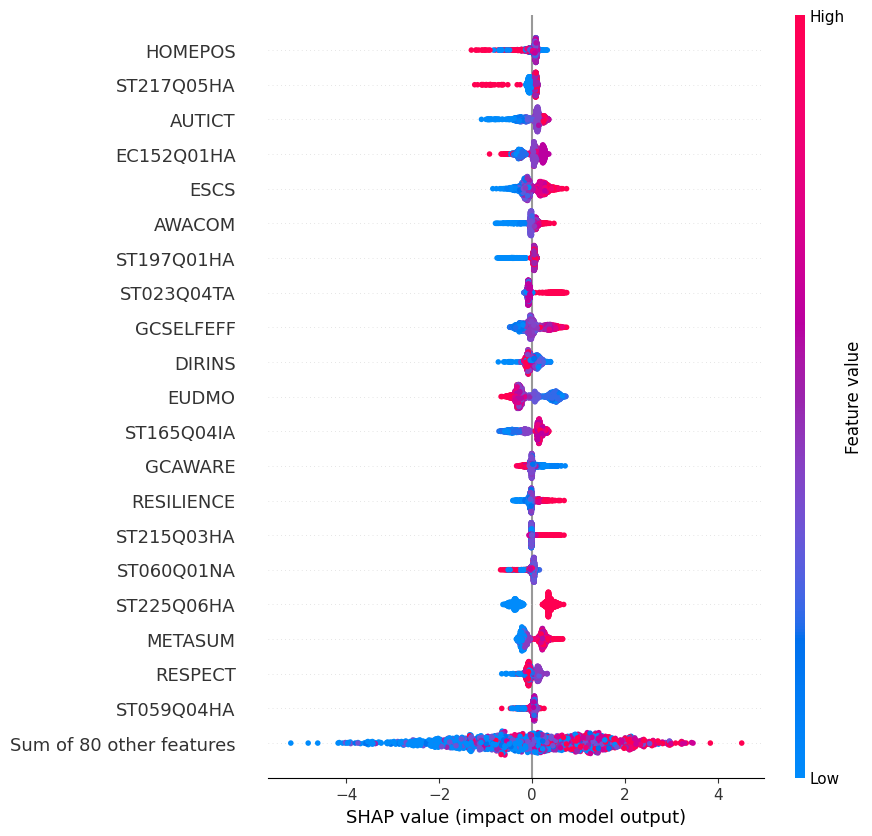

In [27]:
shap.plots.beeswarm(shap_values,max_display=21,order=shap_values.abs.max(0))

In [24]:
ㄕ